# Theoretical Background

Let us start with broadly defining what is Linear Programming and its main usage:

## Linear Programming or Linear Optimization:

Method for solving a specific kind of mathematical optimization problems, namely problems with the following setting:

- Linear function Z that needs to be optimized (minimized/maximized);
- A set of linear constraints (equalities/inequalities) on the solution;
- Non-Negativity restrictions, if needed.

A standard formulation of a linear programming problem would be:

Find vector $\mathbf{x}$ that maximizes $\mathbf{c^Tx}$ subject to constraints $\mathbf{Ax} <= \mathbf{b}$ and $\mathbf{x} >= 0$.

## Optimal Transport as a linear programming problem

Let us consider the original Kantorovich problem:

$$L_C(\mathbf{a, b}) = \min_{P\in \mathbf{U(a, b)}} \langle P, C \rangle$$

$$\mathbf{U(a, b)} = \{P \in \mathbb{R}^{n*m}_{+}: P1_m = \mathbf{a} \:\: \& \:\: P^T1_m = \mathbf{b}\}$$

To present this as a linear programming problem, as we already have the objective function $Z = \langle P, C \rangle$, we need to properly encode the constraints on $P$ as a matrix-vector equality. This can be achieved by:
1) Constructing $\mathbf{p} = vec(P)$, which basically means that we transform matrix $P$ into a vector by stacking its columns one over another;
2) Constructing the matrix representing our constraint equations - it is done using the formula $A = \bigl( \begin{matrix}\mathbf{1_m}\otimes I_n\\ I_m \otimes \mathbf{1_n^T}\end{matrix} \bigr)$. $\otimes$ in this formula corresponds to Kronecker's product, in which we multiply each element of the first matrix by the second matrix. As a result, $A \in \mathbb{R}^{(n+m)*nm}$ and encodes all $n+m$ contraints on each row and column of $P$.
3) Combining the previous two steps, we get the system $A\mathbf{p}= \bigl[ \begin{matrix} \mathbf{a} \\ \mathbf{b} \end{matrix} \bigr]$. The only thing left to note is that $\mathbb{p} \in \mathbb{R}^{nm}_{+}$.

Therefore, Kantovich OT problem can be rewritten as:

$$L_C(\mathbf{a, b}) = \min_{\substack{A\mathbf{p}= \bigl[ \begin{matrix} \mathbf{a} \\ \mathbf{b} \end{matrix} \bigr] \\ p \in \mathbb{R}^{nm}_{+}}} \mathbf{c^Tp}, \:\:\:\:\: \mathbf{c} = vec(C)$$

## Dual problem

As with the original OT problem, this linear programming representation also has a different representation. To derive it (or rather, a weak duality equivalent as presented in the book), let us first construct the Lagrangian:

$$H(\mathbf{h}) = \min_{p \in \mathbb{R}^{nm}_{+}} \mathbf{c^Tp} - \mathbf{h^T}(A\mathbf{p - q}), \:\:\:\:\: \mathbf{q} = \bigl[ \begin{matrix} \mathbf{a} \\ \mathbf{b} \end{matrix} \bigr]$$

This Lagrangian, due to relaxed constraints on $\mathbf{p}$, is bound to be no bigger than $L_C(\mathbf{a, b})$
Therefore, to approach $L_C(\mathbf{a, b})$ we need to maximize $H(\mathbf{h})$:

$$ L^1_C(\mathbf{a, b}) = \max_\mathbf{h}H(\mathbf{h}) = \max_\mathbf{h}\mathbf{h^Tq} + \min_{p \in \mathbb{R}^{nm}_{+}}(\mathbf{c}-A^T\mathbf{h})^T\mathbf{p}$$

The only part left to note from the above equation is that $(\mathbf{c}-A^T\mathbf{h})$ has to be non-negative - otherwise, min can reach negative infinity and spoil our calculations. So, final representation for the dual problem is:

$$L^1_C(\mathbf{a, b}) = \max_{\substack{\mathbf{h} \in \mathbb{R}^{n+m} \\ \mathbf{\mathbf{c} \geq A^T\mathbf{h}}}}\mathbf{h^Tq}$$

Or, equivalently,

$$L^1_C(\mathbf{a, b}) = \max_{\substack{\mathbf{h} \in \mathbb{R}^{n+m} \\ \mathbf{\mathbf{c} \geq A^T\mathbf{h}}}}\bigl[ \begin{matrix} \mathbf{a} \\ \mathbf{b} \end{matrix} \bigr]^T\mathbf{h}$$

## Linear programming solution methods

### Simplex method:

Intuition: All the constraints combined form a feasible region, where the optimal solution lies. As the objective function is linear, it is component-wise monotone, and therefore the optimal solution has to exist somewhere at the border of the feasible region, more specifically - one of the vertices formed by the intersection of constraints should have this optimal value. This method is therefore "traveling" over the edges of the feasible region while picking the most "profitable" direction so as to finally reach the solution.

Algorithm (according to provided jupiter notebooks, bold text - my notes):

1. Initialization: Start with an initial basic feasible solution. For the optimal transport problem, this could be an initial transportation plan that satisfies all supply and demand constraints.

2. Optimality Test: Check if the current solution is optimal by examining the reduced costs. If all reduced costs are non-negative, the current solution is optimal.

    **At this point during every iteration, we end up with an equation $Z - (a_1x_1 - a_1x_2 + ...) + (b_1y_1 + b_2y_2 + ...) = const$. Achieving the above condition would then mean that the first bracket is empty, and further changing any variable would only decrease $Z$.**

3. Pivot Selection: If the current solution is not optimal, select an entering variable (one with a negative reduced cost) to enter the basis. This corresponds to increasing the amount transported along a certain route.

    **Usually the variable with largest absolute cost is chosen, as that means it will affect the value more drastically and thus optimize it quicker.**

4. Determine Leaving Variable: Determine the leaving variable by performing a ratio test to ensure feasibility. This involves finding which variable should leave the basis to maintain the feasibility of the solution.

    **At this step we determine which of the constraint equations has the harshest restrictions over the chosen variable, and pick it and its corresponding base variable.**

5. Update Solution: Perform a pivot operation to update the basic feasible solution. This involves adjusting the transportation quantities and updating the basis.

    **Carry out operations similar to that of matrix RREF transformation - make the cofficient of the corresponding variable in the chosen constraint equal to 1, then via elementary row operations make it the only non-zero element in the column.** 

Repeat: Repeat the optimality test, pivot selection, and update steps until an optimal solution is found.


In [3]:
import numpy as np
from scipy.optimize import linprog

In [4]:
def get_constraints_matrix(n, m):
    A = np.zeros((n + m, n * m))
    for i in range(n):
        A[i, i * m:(i + 1) * m] = 1
    for i in range(m):
        A[n + i, i::m] = 1
    return A

In [80]:
def ot_lp_solver(cost_matrix, a, b):

    cost_matrix = np.array(cost_matrix)
    a = np.array(a)
    b = np.array(b)
    c = cost_matrix.flatten()
    A_check = get_constraints_matrix(a.size, b.size)

    expected_check = np.concatenate((a, b))

    result = linprog(c, A_eq=A_check, b_eq=expected_check)

    if result.success:
        print("Solution matrix: \n", result.x.reshape(cost_matrix.shape), '\n')
        print("Optimal cost:", result.fun, '\n')
        return result.x.reshape(cost_matrix.shape)
    else:
        raise ValueError("Optimization failed:", result.message)

res = ot_lp_solver([[4, 6, 8], [5, 3, 2]], [40, 60], [50, 30, 20])

Solution matrix: 
 [[40.  0.  0.]
 [10. 30. 20.]] 

Optimal cost: 340.0 



In [103]:
def ot_dual_solver(cost_matrix, a, b):
    cost_matrix = np.array(cost_matrix)
    a = np.array(a)
    b = np.array(b)
    c = cost_matrix.flatten()
    A_check = get_constraints_matrix(a.size, b.size).transpose()

    conc_result = -np.concatenate((a, b)).transpose() # negation because linprog minimizes

    result = linprog(conc_result, A_ub=A_check, b_ub=c)

    if result.success:
        print("Calculated h: \n", result.x, '\n')
        print("Optimal cost:", -result.fun, '\n')
        return result.x
    else:
        raise ValueError("Optimization failed:", result.message)

res = ot_dual_solver([[4, 6, 8], [5, 3, 2]], [40, 60], [50, 30, 20])

Calculated h: 
 [1. 2. 3. 1. 0.] 

Optimal cost: 340.0 



In [82]:
M = 9999

def get_constraints_tableau(n, m):
    A = np.zeros((n + m, n * m + n + m + 1), dtype=np.float64)
    for i in range(n):
        A[i, i * m:(i + 1) * m] = 1
        A[i, n * m + i] = 1
    for i in range(m):
        A[n + i, i:n*m:m] = 1
        A[n + i, n * m + n + i] = 1
    return A

def extract_solution(A, n, m):
    decision_variables = np.zeros(n * m)

    for j in range(n * m):
        column = A[:, j]
        if np.count_nonzero(column) == 1 and np.sum(column) == 1:
            row = np.where(column == 1)[0][0]
            decision_variables[j] = A[row, -1]

    return decision_variables.reshape(n, m)


def manual_solver(cost_matrix, a, b):
    cost_matrix = np.array(cost_matrix)
    a = np.array(a)
    b = np.array(b)
    n, m = cost_matrix.shape
    c = cost_matrix.flatten()

    A = get_constraints_tableau(n, m)
    vals = np.concatenate((a, b))
    A[:, -1] = vals

    main = np.concatenate((c,  np.array([M for _ in range(n + m)])))
    main = np.concatenate((main, np.array([0])), dtype=np.float64)

    for i in range(n + m):
        main += -M * A[i]

    while True:

        no_value = main[:-1]
        if np.all(no_value >= 0):
            res =  extract_solution(A, n, m)
            print("Solution matrix: \n", res, '\n')
            print("Optimal cost:", -main[-1], '\n')
            return res

        entering = np.argmin(no_value)
        ratios = np.zeros(n + m)
        for i in range(n + m):
            if A[i, entering] > 0:
                ratios[i] = A[i, -1] / A[i, entering]
            else:
                ratios[i] = np.inf

        leaving = np.argmin(ratios)
        A[leaving] /= A[leaving, entering]
        for i in range(n + m):
            if i == leaving:
                continue
            A[i] -= A[i, entering] * A[leaving]

        main -= A[leaving] * main[entering]


res = manual_solver([[4, 6, 8], [5, 3, 2]], [40, 60], [50, 30, 20])

Solution matrix: 
 [[40.  0.  0.]
 [10. 30. 20.]] 

Optimal cost: 340.0 



(<Axes: >, <Axes: >, <Axes: >)

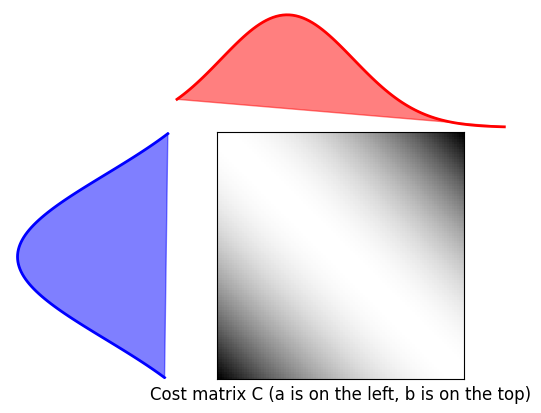

In [104]:
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

n = 100  # problem size

# Initialize marginals as normal distribution restricted to [0, n], normalized to 1
a = gauss(n, m=n/2, s=n/3)  # m=mean, s=std
b = gauss(n, m=n/3, s=n/5)

# Initialize cost matrix 
x = np.arange(n, dtype=np.float64)
C = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
C = C / C.max()

ot.plot.plot1D_mat(a, b, C, 'Cost matrix C (a is on the left, b is on the top)')

Solution matrix: 
 [[4.48490670e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.27723379e-04 3.96150335e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69704778e-03 3.20139665e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.31752235e-04
  1.12225079e-04 9.53533839e-05]] 

Optimal cost: 0.02662906217731249 



(<Axes: >, <Axes: >, <Axes: >)

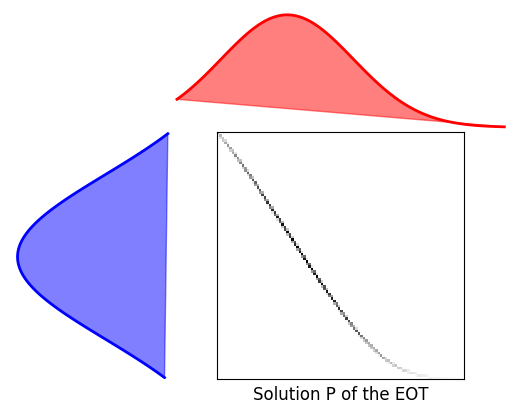

In [105]:
res = ot_lp_solver(C, a, b)

ot.plot.plot1D_mat(a, b, res, 'Solution P of the EOT')

In [106]:
_ = manual_solver(C, a, b)

Solution matrix: 
 [[4.48490670e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.27723379e-04 3.96150335e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69704778e-03 3.20139665e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.31752235e-04
  1.12225079e-04 9.53533839e-05]] 

Optimal cost: 0.026629062177992324 

